In [1]:
import numpy as np
import numpy as np
import scipy as sp
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib import ticker
from skimage import measure
%matplotlib notebook

<IPython.core.display.Javascript object>


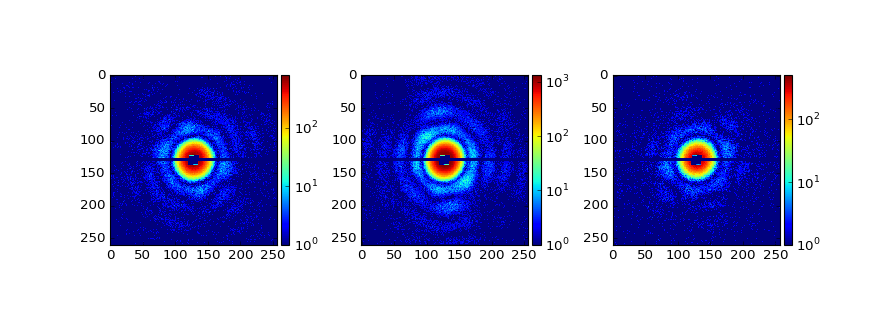

In [3]:
frame_names = ['frame_9.bin','frame_10.bin','frame_13.bin']

fig = plt.figure(figsize=(11,4))
plt.subplots_adjust(wspace=0.4)
for i,fname in enumerate(frame_names):
    frame = np.fromfile(fname,dtype=np.float64).reshape(260,257)
    # print frame.shape
    ax = plt.subplot(131+i)
    im = ax.imshow(frame+1, interpolation='nearest', norm=LogNorm(vmin=1, vmax=np.amax(frame)))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

plt.show()
fig.savefig('exp_example.png', dpi=300, bbox_inches='tight')


In [2]:
def get_indexes_range(indexes):
    min_x = np.amin(indexes)
    max_x = np.amax(indexes)
    total_range = max_x - min_x
    return min_x - total_range/10, max_x + total_range/10

def plot_3d_array(data, level=0, step=1, range_x=0, range_y=0, range_z=0):
    if level == 0:
        level = np.mean(data)
    
    verts, faces, normals, values = measure.marching_cubes_lewiner(data, level, step_size=step)
    
    fig = plt.figure(figsize=(11,4))
    ax = fig.gca(projection='3d')
    ax.set_title('3d image')
    mesh = Poly3DCollection(verts[faces],linewidths=0.2)
    ax.add_collection3d(mesh)
    
    selected_x, selected_y, selected_z = (data >= level).nonzero()
    if range_x == 0:
        range_x = get_indexes_range(selected_x)
    if range_y == 0:
        range_y = get_indexes_range(selected_y)
    if range_z == 0:
        range_z = get_indexes_range(selected_z)
    
    ax.set_xlim(*range_x)
    ax.set_ylim(*range_y)
    ax.set_zlim(*range_z)
    plt.show()
    
def _prepare_subplot(axes, data_2d, vmin, logscale):
    if logscale:
        norm = LogNorm(vmin=vmin, vmax=np.amax(data_2d))
    else:
        norm = None
        
    im = axes.imshow(data_2d+vmin, cmap='jet', norm=norm)    
    divider = make_axes_locatable(axes)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    
def plot_3d_cuts(data, shift=0, vmin=1, logscale=True):
    sz,sy,sx = data.shape
    fig = plt.figure(figsize=(14,4))
    plt.subplots_adjust(wspace=0.4)
    ax1 = fig.add_subplot(131)
    ax1.set_title('X')
    _prepare_subplot(ax1, data[:,:,sx//2+shift], vmin, logscale)
    ax2 = fig.add_subplot(132)
    ax2.set_title('Y')
    _prepare_subplot(ax2, data[:,sy//2+shift,:], vmin, logscale)
    ax3 = fig.add_subplot(133)
    ax3.set_title('Z')
    _prepare_subplot(ax3, data[sz//2+shift,:,:], vmin, logscale)
    plt.show()
    return fig

def plot_3d_projections(data, vmin=1, logscale=True):
    sz,sy,sx = data.shape
    fig = plt.figure(figsize=(11,4))
    plt.subplots_adjust(wspace=0.4)
    ax1 = fig.add_subplot(131)
    ax1.set_title('X')
    _prepare_subplot(ax1, np.mean(data,axis=2), vmin, logscale)
    ax2 = fig.add_subplot(132)
    ax2.set_title('Y')
    _prepare_subplot(ax2, np.mean(data,axis=1), vmin, logscale)
    ax3 = fig.add_subplot(133)
    ax3.set_title('Z')
    _prepare_subplot(ax3, np.mean(data,axis=0), vmin, logscale)
    plt.show()
    return fig
    
def plot_graph(*args,**kwargs):
    fig = plt.figure(figsize=(11,4))
    ax = fig.add_subplot(111)
    ax.plot(*args,**kwargs)
    plt.show()
    
def generate_mask(res, rad_min=0, rad_max=0):
    (res_x, res_y, res_z) = np.mgrid[0:res, 0:res, 0:res]
    res_x -= res//2
    res_y -= res//2
    res_z -= res//2
    radius = np.sqrt(res_x*res_x + res_y*res_y + res_z*res_z)
    
    if rad_max == 0:
        rad_max = np.amax(radius)
        
    mask = np.zeros_like(radius, dtype=bool)
    mask[(radius > rad_min) & (radius <= rad_max)] = True
    
    return mask


def apply_binning(data, bin_value):
    Z,Y,X = data.shape

    newX = X//bin_value
    newY = Y//bin_value
    newZ = Z//bin_value

    new_data = data[:newZ*bin_value,:newY*bin_value,:newX*bin_value].reshape(newZ,bin_value,newY,bin_value,newX,bin_value).sum(axis=(1,3,5))

    return new_data

def read_3d_array(filename):
    data = np.fromfile(filename, dtype=np.float64)
    orig_res = int(round(np.cbrt(data.shape[0])))
    data = data.reshape(orig_res, orig_res, orig_res)
    return data

(367, 367, 367)


<IPython.core.display.Javascript object>


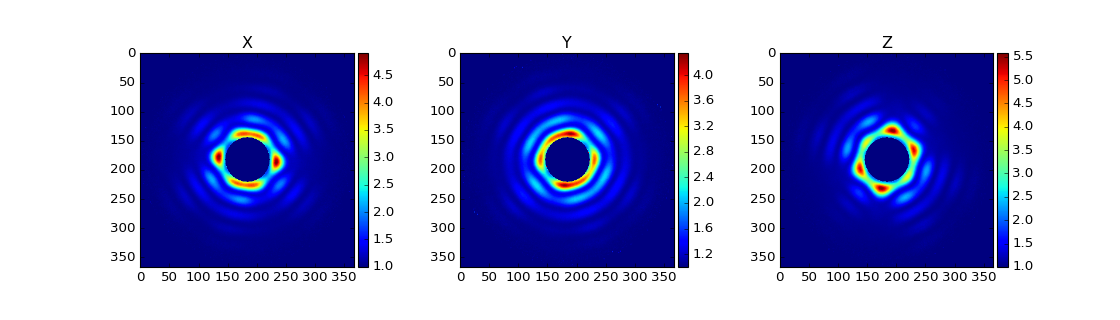

In [17]:
recovered_intens = read_3d_array("intens_040.bin")
print recovered_intens.shape
fig = plot_3d_cuts(recovered_intens, logscale=False)

fig.savefig('exp_recovered_intensity.png', dpi=300, bbox_inches='tight')

In [3]:
reconst = sio.loadmat("recon_final_thresh_0.25.mat")
real_result = np.abs(reconst['real_space'][-1])
print real_result.shape, real_result.dtype
data_size = real_result.shape[0]

(183, 183, 183) float64


<IPython.core.display.Javascript object>


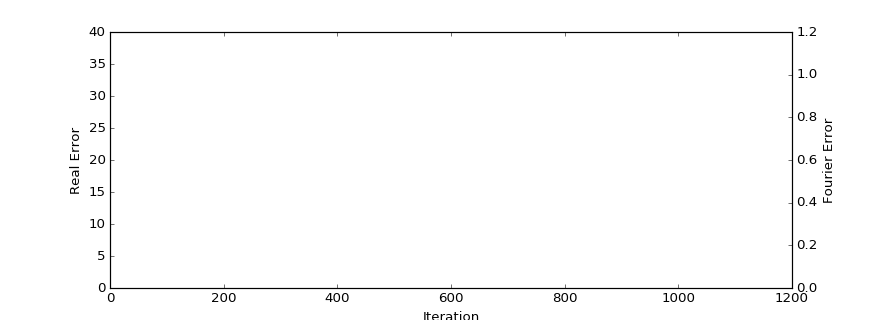

float64


In [32]:
rerror  = reconst["real_error"]
ferror  = reconst["fourier_error"]
error_iter = reconst['iteration_index_scores']
fig = plt.figure(figsize=(11,4))
ax1 = fig.add_subplot(111)
ax1.plot(error_iter, rerror, color='r')
ax2 = ax1.twinx()

ax1.set_xlabel('Iteration')
ax1.set_ylabel('Real Error')

ax2.plot(error_iter, ferror, color='b')
ax2.set_ylabel('Fourier Error')
plt.show()

plt.savefig('exp_error.png', bbox_inches='tight')

print error_iter.dtype

In [21]:
plt.plot(rerror)
plt

<IPython.core.display.Javascript object>


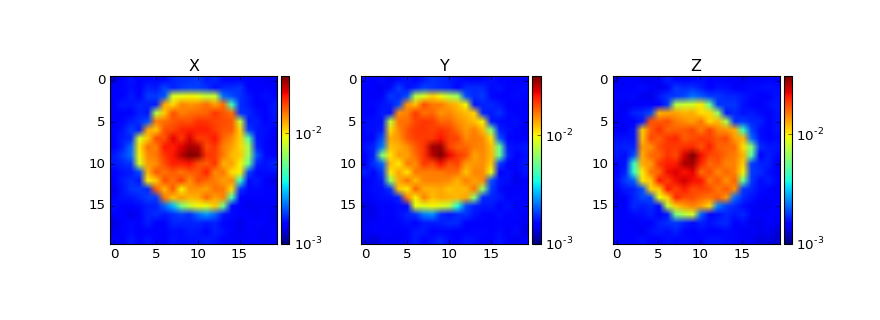

In [7]:
def select_data(data, thresh):
    z_max = np.amax(data, axis=(1,2))
    y_max = np.amax(data, axis=(0,2))
    x_max = np.amax(data, axis=(0,1))
    
    z_range = np.nonzero(z_max >= thresh)[0]
    y_range = np.nonzero(y_max >= thresh)[0]
    x_range = np.nonzero(x_max >= thresh)[0]
    
    return data[z_range[0]:z_range[-1], y_range[0]:y_range[-1], x_range[0]:x_range[-1]]
    
selected_result = real_result[82:102,82:102,82:102]
# selected_result = select_data(real_result,0.0015)
fig = plot_3d_projections(selected_result,vmin=0.001, logscale=True)
fig.savefig('exp_recovered_density.png', dpi=300, bbox_inches='tight')

<IPython.core.display.Javascript object>


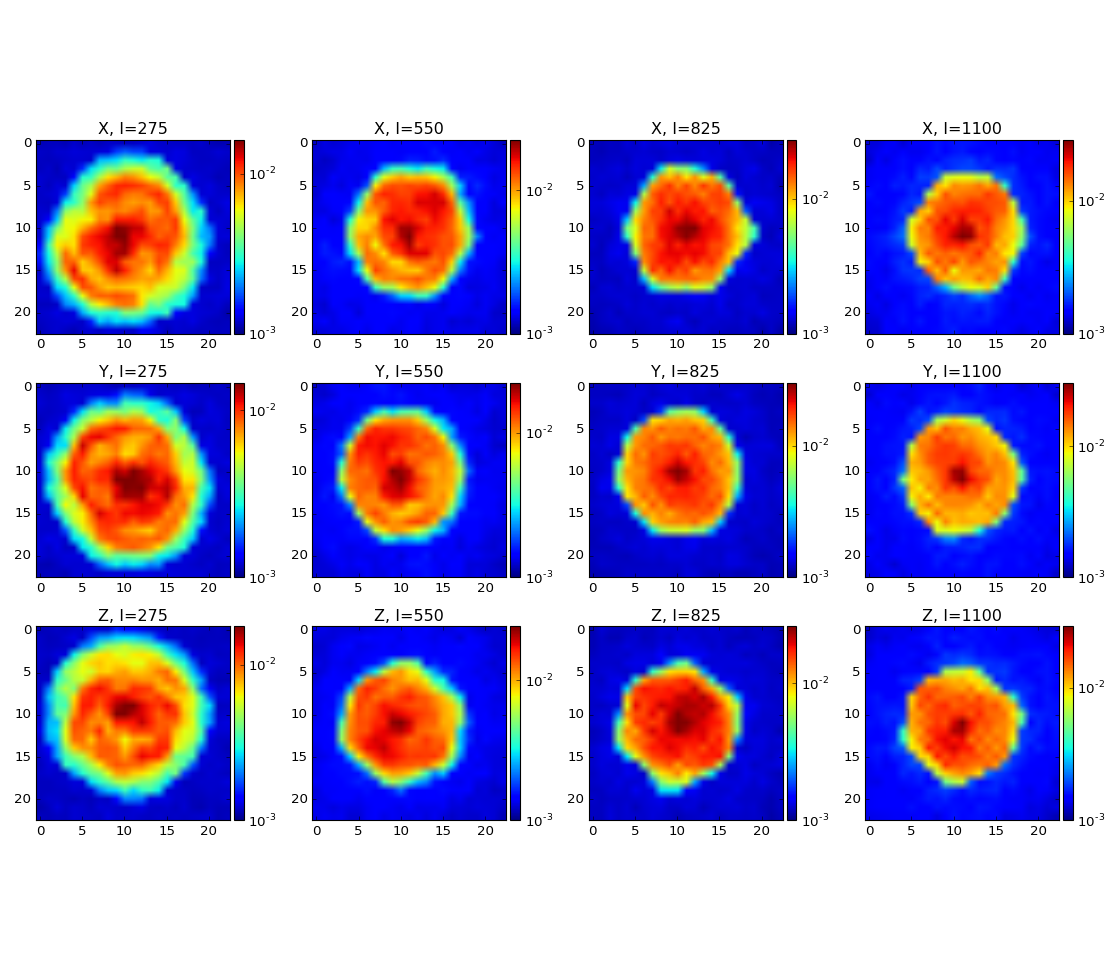

In [9]:
def plot_progress(data, image_iter, vmin=1, center_cut=False, logscale=True):
    if len(data.shape) == 3:
        sn,sy,sx = data.shape
        fig = plt.figure(figsize=(14,4))
        plt.subplots_adjust(wspace=0.3)
        for i in range(5):
            ax1 = fig.add_subplot(1,5,i+1)
            ax1.set_title('I=%d'%image_iter[i])
            _prepare_subplot(ax1, data[i,:,:], vmin, logscale)  
    elif len(data.shape) == 4:
        sn,sz,sy,sx = data.shape
        fig = plt.figure(figsize=(14,12))
        plt.subplots_adjust(wspace=0.2, hspace=-0.6)
        isize = data.shape[0]
        for i in range(isize):
            ax1 = fig.add_subplot(3,isize,i+1)
            ax1.set_title('X, I=%d'%image_iter[i])
            if center_cut:
                _prepare_subplot(ax1, data[i,:,:,sx//2], vmin, logscale)
            else:
                _prepare_subplot(ax1, np.mean(data[i,:,:,:], axis=2), vmin, logscale)
        for i in range(isize):
            ax1 = fig.add_subplot(3,isize,i+1+isize)
            ax1.set_title('Y, I=%d'%image_iter[i])
            if center_cut:
                _prepare_subplot(ax1, data[i,:,sy//2,:], vmin, logscale)
            else:
                _prepare_subplot(ax1, np.mean(data[i,:,:,:], axis=1), vmin, logscale)
        for i in range(isize):
            ax1 = fig.add_subplot(3,isize,i+1+2*isize)
            ax1.set_title('Z, I=%d'%image_iter[i])
            if center_cut:
                _prepare_subplot(ax1, data[i,sz//2,:,:], vmin, logscale)
            else:
                _prepare_subplot(ax1, np.mean(data[i,:,:,:], axis=0), vmin, logscale)
    plt.tight_layout()
    plt.show()
    
range_start = int(data_size//2*0.88)
range_end = int(data_size//2*1.14)
result = np.abs(reconst['real_space'][1:,range_start:range_end,range_start:range_end,range_start:range_end])
image_iter = reconst['iteration_index_images'][0]

plot_progress(result, image_iter[1:], 0.001)
plt.savefig('exp_progress_real.png', dpi=300, bbox_inches='tight')

<IPython.core.display.Javascript object>


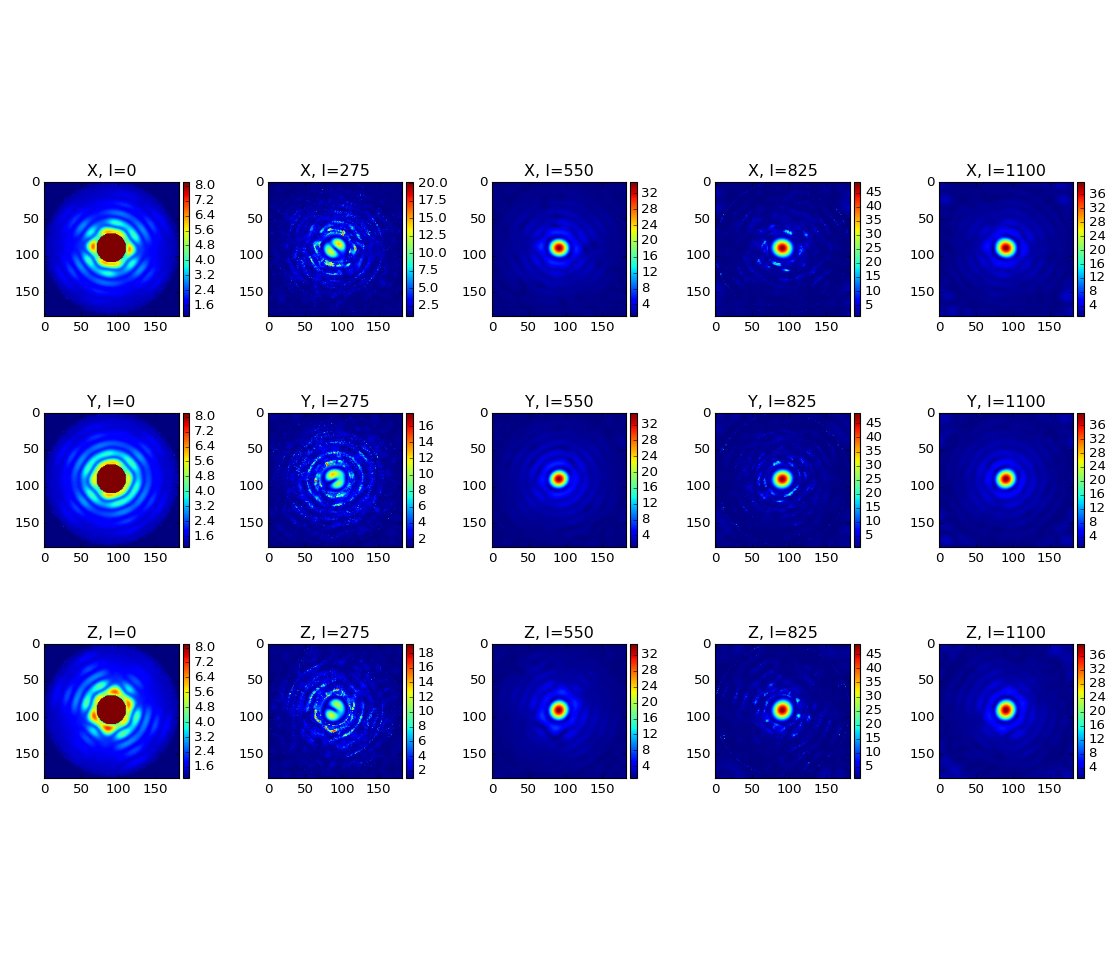

In [14]:

plot_progress(np.abs(reconst['fourier_space']), image_iter, vmin=1, center_cut=True, logscale=False)
plt.savefig('exp_progress_fourier.png', dpi=300, bbox_inches='tight')